#### Instalujemy potrzebne dla nas bibliotek

%pip install cvxpy
%pip install pandas
%pip install yfinance
%pip install matplotlib
%pip install seaborn

#### Importujemy poniższe biblioteki

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
import seaborn as sns

## 1. Pobierz notowania dla amerykańskich spółek giełdowych:
- InterActiveCorp,
- LiveRamp Holding, Inc.,
- Olimpic Steel, Inc.,
- Zimmer Biomet Holdings, Inc.,
- AptarGroup, Inc.,
- MetLife, Inc..

Pobieramy potrzebne dane spółek za pomocą biblioteki yfinance.

Skróty spółek `"Ticker"` są następujące:
- `IAC` InterActiveCorp,

- `RAMP` LiveRamp Holding, Inc.,

- `ZEUS` Olimpic Steel, Inc.,

- `ZBH` Zimmer Biomet Holdings, Inc.,

- `ATR` AptarGroup, Inc.,

- `MET` MetLife, Inc..


In [3]:
# Za pomocą nawiasu ["Close"] pobieramy jedynie ostatnie wartości danego dnia. 
spolki_gieldowe = yf.download(['IAC', 'RAMP', 'ZEUS', 'ZBH', 'ATR', 'MET'], start='2004-01-01', end='2018-01-01')['Close'] 
# Upewniamy się, że numeracja indeksów jest w prawidłowej kolejności.
spolki_gieldowe.reset_index(inplace=True)
spolki_gieldowe["Date"] = pd.to_datetime(spolki_gieldowe["Date"]).dt.tz_localize(None).dt.date

[*********************100%***********************]  6 of 6 completed


In [4]:
# Tak samo robimy dla kursu złotówki do dolara.
waluta = yf.Ticker("PLN=X")
waluta = waluta.history(start='2004-01-01', end='2018-01-01')
# Wybieramy jedynie kolumnę "Close" ponieważ to ona nas interesuje.
waluta = waluta['Close'] 
# Upewniamy się, że numeracja indeksów jest w prawidłowej kolejności tak samo jak w przypadku spółek giełdowych.
waluta = waluta.reset_index()
waluta["Date"] = pd.to_datetime(waluta["Date"]).dt.tz_localize(None).dt.date
# Zmieniamy nazwę kolumny "Close" na wygodniejszą do zrozumienia "PLN-USD".
waluta = waluta.rename(columns={"Close":"PLN-USD"})

In [5]:
# Sprawdzamy czy nie brakuje nam danych z całego okresu dla obu zbiorów danych. Jeżeli w zbiorze "spółki giełdowe" lub "waluta"
# brakuje danych dla konkretnej daty pozbywamy się ich gdyż nie możemy pozyskać wartościowych danych w procesie przewalutowania 
# akcji w naszym portfelu.
spolki_gieldowe_unique_dates = spolki_gieldowe['Date'].unique()
waluta_unique_dates = waluta['Date'].unique()

missing_dates_spolki_gieldowe = set(spolki_gieldowe_unique_dates) - set(waluta_unique_dates)
missing_dates_waluta = set(waluta_unique_dates) - set(spolki_gieldowe_unique_dates)
waluta = waluta[~waluta['Date'].isin(missing_dates_spolki_gieldowe) & 
                ~waluta['Date'].isin(missing_dates_waluta)].reset_index(drop=True)
spolki_gieldowe = spolki_gieldowe[~spolki_gieldowe['Date'].isin(missing_dates_spolki_gieldowe) & 
                                  ~spolki_gieldowe['Date'].isin(missing_dates_waluta)].reset_index(drop=True)

# Pozbywamy się brakujących, niekompatybilnych danych. Jest ich zaledwie 30 na przestrzeni 14 lat.

In [6]:
spolki_gieldowe

Ticker,Date,ATR,IAC,MET,RAMP,ZBH,ZEUS
0,2004-01-02,19.280001,7.025336,29.910873,18.809999,67.961166,8.110000
1,2004-01-05,19.799999,7.173193,30.213903,19.000000,67.349518,7.350000
2,2004-01-06,19.895000,7.033785,29.964350,19.000000,67.019417,7.880000
3,2004-01-07,19.815001,6.970418,29.679144,19.150000,67.766991,7.240000
4,2004-01-08,19.924999,6.898601,29.483067,18.920000,69.077667,7.380000
...,...,...,...,...,...,...,...
3490,2017-12-22,85.900002,27.661333,50.759998,27.549999,116.621361,22.150000
3491,2017-12-26,85.389999,27.081833,50.669998,27.430000,116.466019,22.200001
3492,2017-12-27,85.620003,27.116690,50.750000,27.370001,116.640778,21.830000
3493,2017-12-28,86.750000,26.850904,50.869999,27.490000,118.203880,21.700001


In [7]:
waluta

,Date,PLN-USD
0,2004-01-02,3.73590
1,2004-01-05,3.68360
2,2004-01-06,3.64570
3,2004-01-07,3.68360
4,2004-01-08,3.67860
...,...,...
3490,2017-12-22,3.53896
3491,2017-12-26,3.53175
3492,2017-12-27,3.53931
3493,2017-12-28,3.51974


#### W tym momencie obie tabele posiadają takie same rozmiary. To jest 3495 wierszy i odpowiadające sobie daty.

## 2. Oblicz logarytmiczne stopy zwrotu dla każdej ze spółek. Które ze spółek miała największą średnią stopę zwrotu? Która najmniejsze odchylenie standardowe? Która najlepszy wskaźnik Sharpe'a?


W tym celu tworzymy nowy DataFrame przy pomocy Biblioteki `Pandas`. Odseparowujemy oba zbiory w celu większej przejrzystości.

In [8]:
logarytmiczne_stopy_zwrotu = pd.DataFrame({
    "Date": spolki_gieldowe["Date"],
    "Ln ATR": np.log(spolki_gieldowe["ATR"].pct_change() + 1),
    "Ln IAC": np.log(spolki_gieldowe["IAC"].pct_change() + 1),
    "Ln MET": np.log(spolki_gieldowe["MET"].pct_change() + 1),
    "Ln RAMP": np.log(spolki_gieldowe["RAMP"].pct_change() + 1),
    "Ln ZBH": np.log(spolki_gieldowe["ZBH"].pct_change() + 1),
    "Ln ZEUS": np.log(spolki_gieldowe["ZEUS"].pct_change() + 1)
})
logarytmiczne_stopy_zwrotu

,Date,Ln ATR,Ln IAC,Ln MET,Ln RAMP,Ln ZBH,Ln ZEUS
0,2004-01-02,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-01-05,0.026614,0.020828,0.010080,0.010050,-0.009041,-0.098398
2,2004-01-06,0.004787,-0.019626,-0.008294,0.000000,-0.004913,0.069628
3,2004-01-07,-0.004029,-0.009050,-0.009564,0.007864,0.011093,-0.084707
4,2004-01-08,0.005536,-0.010357,-0.006628,-0.012083,0.019156,0.019152
...,...,...,...,...,...,...,...
3490,2017-12-22,0.001631,-0.000236,-0.005305,0.001817,0.001416,-0.016566
3491,2017-12-26,-0.005955,-0.021172,-0.001775,-0.004365,-0.001333,0.002255
3492,2017-12-27,0.002690,0.001286,0.001578,-0.002190,0.001499,-0.016807
3493,2017-12-28,0.013111,-0.009850,0.002362,0.004375,0.013312,-0.005973


### Statystyki spółek

In [9]:
# Tworzymy potrzebne dla nas funkcje liczące roczną średnią, medianę odchylenie standardowe oraz wskaźnik Sharpa.
def srednia_stopa_zwrotu(x):
    return x.mean() * 250

def mediana(x):
    return x.median() * 250

def odchylenie_standardowe(x):
    return x.std() * np.sqrt(250) 

def sharpa(x):
    return (srednia_stopa_zwrotu(x) - rf) / odchylenie_standardowe(x)

rf = 0.02 # Przyjmujemy następującą średnią stopę zwrotu wolną od ryzyka.

# Tworzymy tabelę "srednie" przy pomocy funkcji .agg() z biblioteki Pandas, 
# która kumuluje dane jednocześnie wykożystując funkcje wymienione w nawiasie [].
srednie = logarytmiczne_stopy_zwrotu.agg({
    "Ln ATR": [srednia_stopa_zwrotu, mediana, odchylenie_standardowe, sharpa],
    "Ln IAC": [srednia_stopa_zwrotu, mediana, odchylenie_standardowe, sharpa],
    "Ln MET": [srednia_stopa_zwrotu, mediana, odchylenie_standardowe, sharpa],
    "Ln RAMP": [srednia_stopa_zwrotu, mediana, odchylenie_standardowe, sharpa],
    "Ln ZBH": [srednia_stopa_zwrotu, mediana, odchylenie_standardowe, sharpa],
    "Ln ZEUS": [srednia_stopa_zwrotu, mediana, odchylenie_standardowe, sharpa],}).T
# Zastępujemy nazwy kolumn na czytelniejsze. 
srednie.columns = ['średnia stopa zwrotu', 'mediana', 'odchylenie standardowe', 'wskaźnik sharpa']
srednie

,średnia stopa zwrotu,mediana,odchylenie standardowe,wskaźnik sharpa
Ln ATR,0.107222,0.156010,0.237293,0.367569
Ln IAC,0.095369,0.000000,0.290860,0.259125
Ln MET,0.037560,0.049795,0.435494,0.040322
Ln RAMP,0.027331,0.000000,0.387938,0.018897
Ln ZBH,0.038964,0.116603,0.264455,0.071711
Ln ZEUS,0.069726,0.000000,0.590566,0.084200


### Wskazujemy interesujące nas wartosci.

In [10]:
wyniki = srednie.agg(
    najwieksza_srednia = ('średnia stopa zwrotu', "max"),                     
    najmniejsze_odchylenie = ('odchylenie standardowe', "min"),
    najwiekszy_sharpa = ('wskaźnik sharpa', "max"))

wyniki.index = ['największa średnia', "najmniejsze odchylenie standardowe", "największy wskaźnik Sharpa"]
wyniki.replace({np.nan:"-"}) # Podmieniam każdy znak NaN na '-' za pomocą numpy.nan i funkcji replace 
# w celu większej czytelności
# Wszystkie wyniki należą do spółki ATR

,średnia stopa zwrotu,odchylenie standardowe,wskaźnik sharpa
największa średnia,0.107222,-,-
najmniejsze odchylenie standardowe,-,0.237293,-
największy wskaźnik Sharpa,-,-,0.367569


## 3. Wybierz wagi dla każdej ze spółek w portfelu. Oblicz stopę zwrotu portfela. Porównaj następujące statystyki portfela z odpowiednikami dla poszczególnych spółek:
- Skumulowana stopa zwrotu,
- Wskaźnik Sharpe'a,
- 95% percentyl,
- Skośność.

#### Zaczynamy od obliczenia macierz kowariancji.

In [11]:
kowariancje = logarytmiczne_stopy_zwrotu[["Ln ATR", "Ln IAC", "Ln MET", "Ln RAMP", "Ln ZBH", "Ln ZEUS"]].cov()
kowariancje

,Ln ATR,Ln IAC,Ln MET,Ln RAMP,Ln ZBH,Ln ZEUS
Ln ATR,0.000225,0.000098,0.000197,0.000147,0.000093,0.000223
Ln IAC,0.000098,0.000338,0.000179,0.000143,0.000088,0.000173
Ln MET,0.000197,0.000179,0.000759,0.000284,0.000183,0.000400
Ln RAMP,0.000147,0.000143,0.000284,0.000602,0.000124,0.000283
Ln ZBH,0.000093,0.000088,0.000183,0.000124,0.000280,0.000187
Ln ZEUS,0.000223,0.000173,0.000400,0.000283,0.000187,0.001395


### Przy pomocy biblioteki `cvxpy` obliczamy optymalne wagi dla naszego portfela.

In [12]:
dlugosc = kowariancje.shape[0] # Tworzymy zmienną zwracającą długość wiersza/kolumny.
wagi_poczatkowe = np.ones(dlugosc) / dlugosc  # Tworzymy wagi początkowe, wszystkie są równe i sumują się do 1.

# Zapisujemy ograniczenia dla problemu minimalizacji. 
wagi= cp.Variable(dlugosc)
risk = cp.quad_form(wagi, kowariancje)
ograniczenia = [cp.sum(wagi) == 1, wagi>= 0]  # Wagi muszą sumować się do 1

# Dzefiniujemy funkcję celu jako problem minimalizacji ryzyka.
cel = cp.Minimize(risk)
problem = cp.Problem(cel, ograniczenia)

# Funkcja poniżej uruchamia solver.
problem.solve()

# Otrzymujemy wynik w postaci wektora wag.
optymalne_wagi= abs(wagi.value)

print("Wagi wyliczone na bazie macierzy kowariancji:\n", 
      np.array([spolki_gieldowe.columns[1:].values, np.round(optymalne_wagi, 6)]).T)

Wagi wyliczone na bazie macierzy kowariancji:
 [['ATR' 0.423921]
 ['IAC' 0.231136]
 ['MET' 0.0]
 ['RAMP' 0.028185]
 ['ZBH' 0.316757]
 ['ZEUS' 0.0]]


### Stopa zwrotu portfela

In [13]:
srednie_stopy_zwrotu = srednie[['średnia stopa zwrotu'][0]].to_list()
udzialy_w_portfelu = []

for i in range(np.size(optymalne_wagi)):
    udzialy_w_portfelu.append(srednie_stopy_zwrotu[i] * optymalne_wagi[i])

udzialy_w_portfelu = np.array(udzialy_w_portfelu)
print("Otrzymujemy następujące udziały w portfelu dla każdej ze spółek:\n", 
      np.array([spolki_gieldowe.columns[1:].values, np.round(udzialy_w_portfelu, 6)]).T)
stopa_zwrotu_portfela = sum(udzialy_w_portfelu)
print("\nStopa zwrotu portfela wynosi =", stopa_zwrotu_portfela)

Otrzymujemy następujące udziały w portfelu dla każdej ze spółek:
 [['ATR' 0.045454]
 ['IAC' 0.022043]
 ['MET' 0.0]
 ['RAMP' 0.00077]
 ['ZBH' 0.012342]
 ['ZEUS' 0.0]]

Stopa zwrotu portfela wynosi = 0.08060926412269045


### Odchylenie portfela do Sharpe'a

In [14]:
# '@' jest symbolem mnożenia macierzy
# '.T' po zmiennej optimal_weights oznacza transponowanie macierzy(w tym przypadku wektora wag).
odchylenie_portfela = np.sqrt(optymalne_wagi @ kowariancje @ optymalne_wagi.T)
print("odchylenie portfela =", odchylenie_portfela)

odchylenie portfela = 0.012312506494508619


### Wskaźnik Sharpe'a dla portfela inwestycyjnego

In [15]:
policzony_sharp = (stopa_zwrotu_portfela - rf) / odchylenie_portfela 
print("Wskaźnik Sharpe'a =", policzony_sharp)

Wskaźnik Sharpe'a = 4.922577230698087


### Dzienna stopa zwrotu portfela

In [16]:
skumulowane_stopy_zwrotu = pd.DataFrame({
    "Date":spolki_gieldowe["Date"],
    "stopa zwrotu portfela":logarytmiczne_stopy_zwrotu[["Ln ATR", "Ln IAC", "Ln MET", "Ln RAMP", "Ln ZBH", "Ln ZEUS"]] @ 
    optymalne_wagi})


### Suma stóp zwrotu portfela

In [17]:
suma_stop_zwrotu_portfela = float(skumulowane_stopy_zwrotu[["stopa zwrotu portfela"]].sum())
print("Suma stóp zwrotu portfela =",suma_stop_zwrotu_portfela)

Suma stóp zwrotu portfela = 1.1265950753787217


C:\Users\Marcin\AppData\Local\Temp\ipykernel_3708\4023431779.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  suma_stop_zwrotu_portfela = float(skumulowane_stopy_zwrotu[["stopa zwrotu portfela"]].sum())


### Przyjmujemy skrót "Skumulowana stopa zwrotu" dla danej spółki jako SSZ <skrót spółki>
### Dla DataFrame skumulowane_stopy_zwrotu dodajemy następujące kolumny:

In [18]:
skumulowane_stopy_zwrotu["SSZ portfela"] = (1 + skumulowane_stopy_zwrotu.fillna(0)["stopa zwrotu portfela"]).cumprod()*100
skumulowane_stopy_zwrotu['SSZ ATR'] = (1 + logarytmiczne_stopy_zwrotu.fillna(0)["Ln ATR"]).cumprod()*100
skumulowane_stopy_zwrotu['SSZ IAC'] = (1 + logarytmiczne_stopy_zwrotu.fillna(0)["Ln IAC"]).cumprod()*100
skumulowane_stopy_zwrotu['SSZ MET'] = (1 + logarytmiczne_stopy_zwrotu.fillna(0)["Ln MET"]).cumprod()*100
skumulowane_stopy_zwrotu['SSZ RAMP'] = (1 + logarytmiczne_stopy_zwrotu.fillna(0)["Ln RAMP"]).cumprod()*100
skumulowane_stopy_zwrotu['SSZ ZBH'] = (1 + logarytmiczne_stopy_zwrotu.fillna(0)["Ln ZBH"]).cumprod()*100
skumulowane_stopy_zwrotu['SSZ ZEUS'] = (1 + logarytmiczne_stopy_zwrotu.fillna(0)["Ln ZEUS"]).cumprod()*100
skumulowane_stopy_zwrotu

,Date,stopa zwrotu portfela,SSZ portfela,SSZ ATR,SSZ IAC,SSZ MET,SSZ RAMP,SSZ ZBH,SSZ ZEUS
0,2004-01-02,NaN,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,2004-01-05,0.013516,101.351569,102.661357,102.082787,101.008012,101.005036,99.095928,90.160247
2,2004-01-06,-0.004063,100.939730,103.152753,100.079317,100.170266,101.005036,98.609034,96.437891
3,2004-01-07,-0.000064,100.933227,102.737129,99.173623,99.212261,101.799311,99.702888,88.268951
4,2004-01-08,0.005680,101.506563,103.305874,98.146527,98.554634,100.569257,101.612823,89.959520
...,...,...,...,...,...,...,...,...,...
3490,2017-12-22,0.001137,237.849460,300.264672,218.274452,44.032763,50.280968,104.791073,23.558732
3491,2017-12-26,-0.007963,235.955384,298.476639,213.653060,43.954621,50.061482,104.651396,23.611853
3492,2017-12-27,0.001851,236.392102,299.279524,213.927874,44.023965,49.951859,104.808309,23.215005
3493,2017-12-28,0.007622,238.193776,303.203523,211.820709,44.127938,50.170385,106.203517,23.076345


### Skośność
Korzystamy z funkcji .skew() z biblioteki `Pandas` w celu obliczenia skośności

In [19]:
print("skośność")
skosnosc = logarytmiczne_stopy_zwrotu[["Ln ATR", "Ln IAC", "Ln MET", "Ln RAMP", "Ln ZBH", "Ln ZEUS"]].skew()
skosnosc

skośność


Ln ATR    -0.248994
Ln IAC     0.245668
Ln MET    -0.424824
Ln RAMP   -0.644189
Ln ZBH    -0.697867
Ln ZEUS   -0.036373
dtype: float64

### 95 percentyl
Korzystamy z funkcji .quantile(q=0.95) z biblioteki `Pandas` w celu obliczenia 95% percentyla.

In [20]:
print("95 percentyl")
percentyl = logarytmiczne_stopy_zwrotu[["Ln ATR", "Ln IAC", "Ln MET", "Ln RAMP", "Ln ZBH", "Ln ZEUS"]].quantile(q=0.95)
percentyl

95 percentyl


Ln ATR     0.022998
Ln IAC     0.028161
Ln MET     0.033786
Ln RAMP    0.034535
Ln ZBH     0.023527
Ln ZEUS    0.058012
Name: 0.95, dtype: float64

## 4. Przedstaw dwa wykresy, które opisują wyniki portfela i poszczególnych spółek

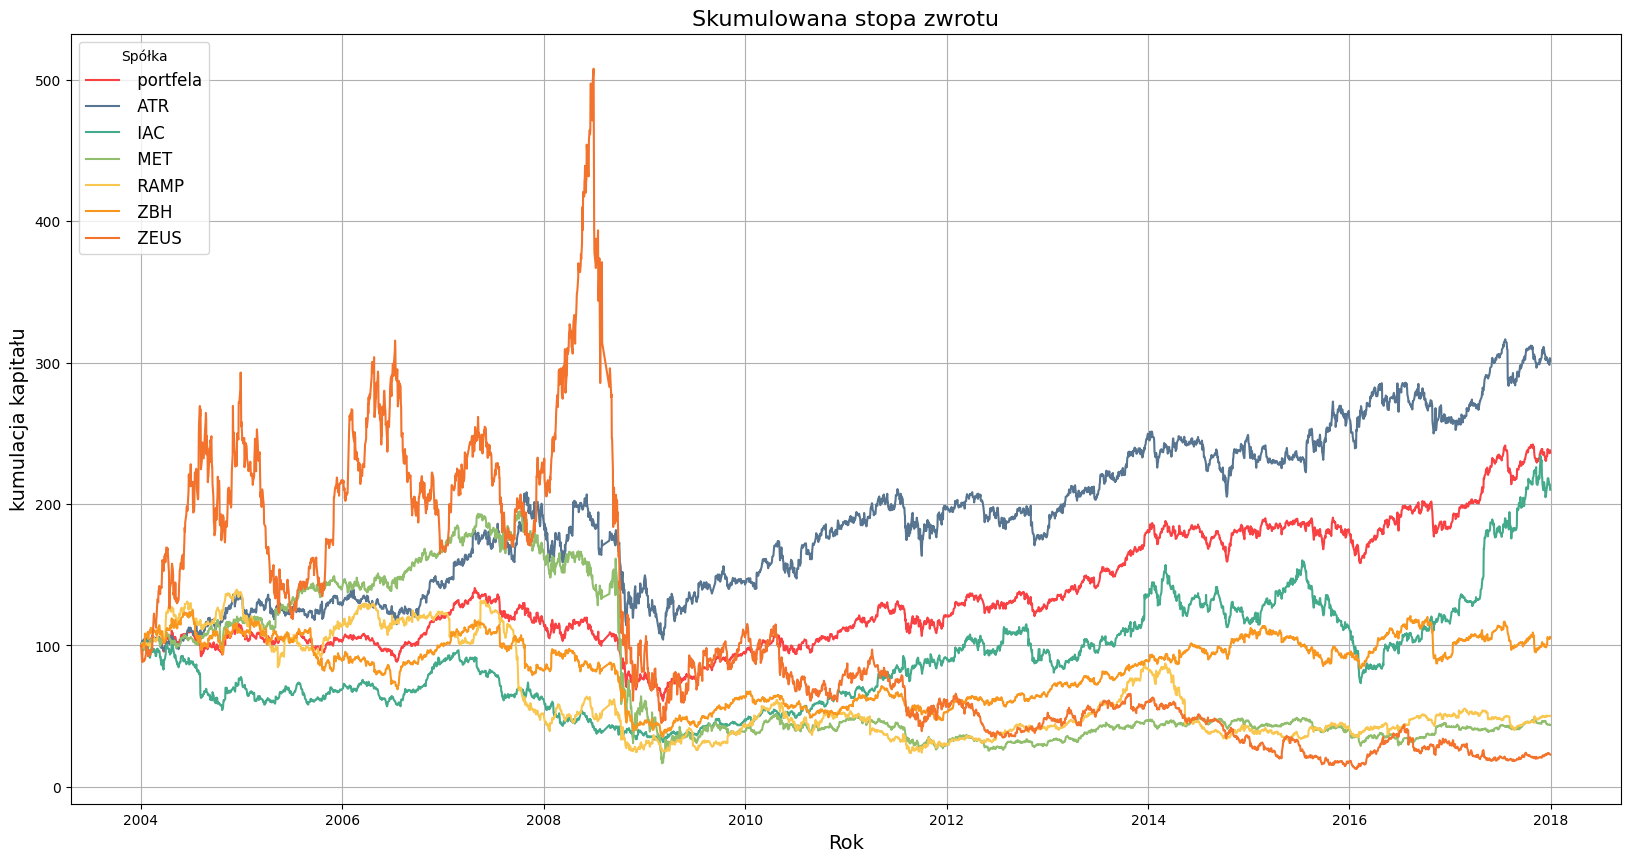

In [21]:
x = skumulowane_stopy_zwrotu["Date"]
y = ["SSZ portfela","SSZ ATR","SSZ IAC","SSZ MET","SSZ RAMP","SSZ ZBH","SSZ ZEUS"]
kolory=["#f94144","#f3722c","#f8961e","#f9c74f","#90be6d","#43aa8b","#577590"]
plt.figure(figsize=(20, 10))
plt.grid()
for spolka in range(len(y)):
    plt.plot(x, skumulowane_stopy_zwrotu[[y[spolka]]], label=y[spolka].replace("SSZ "," "), color=kolory[-spolka])
plt.legend(loc='upper left',title="Spółka", fontsize=12)
plt.xlabel("Rok", fontsize=14)
plt.ylabel("kumulacja kapitału", fontsize=14)
plt.title("Skumulowana stopa zwrotu", fontsize=16)
# plt.autoscale(axis="x", tight=True)
# plt.savefig('wykres1.png',  bbox_inches='tight', pad_inches=0.1)
plt.show()

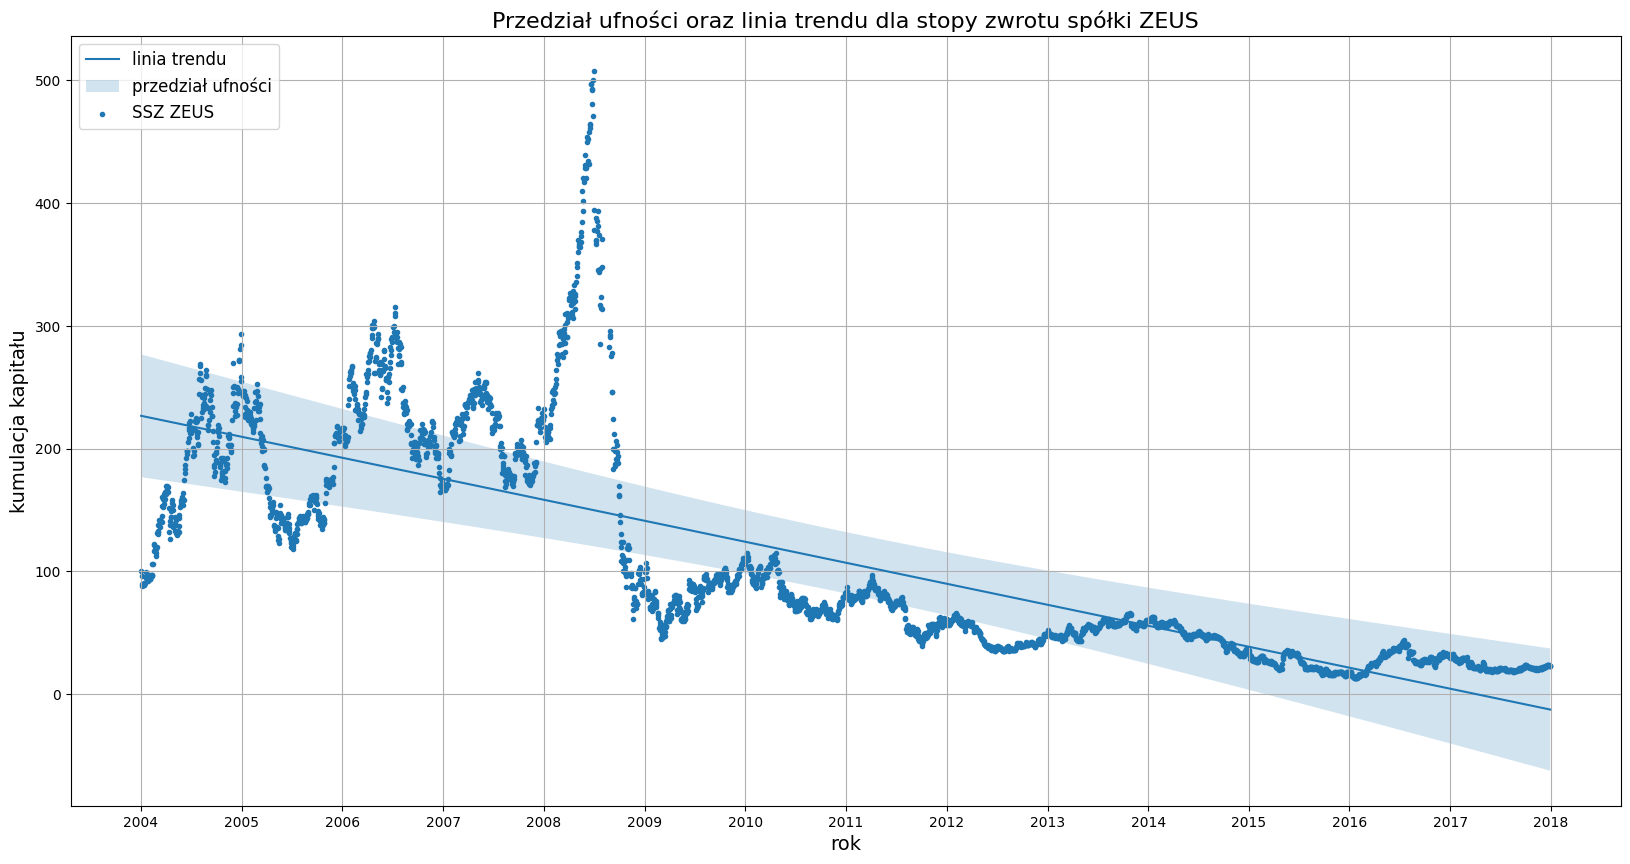

In [22]:
# Na potrzeby utworzenia wykresu przedstawiającego przedział ufnosci musimy przekowertować nasze dane
# na wartości liczbowe, by przeprowadzić na nich kilka pomocniczych operacji.
x = np.array([date.toordinal() - datetime.datetime(1970, 1, 1).toordinal() for date in skumulowane_stopy_zwrotu["Date"]])
y = skumulowane_stopy_zwrotu["SSZ ZEUS"].values

a, b = np.polyfit(x, y, deg=1)
y_est = a * x + b
y_err = x.std() * np.sqrt(1/len(x) + (x - x.mean())**2 / np.sum((x - x.mean())**2))

fig, ax = plt.subplots(figsize=(20, 10))

plt.grid()
ax.plot(x, y_est, label="linia trendu")
ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2, label="przedział ufności")
ax.scatter(x, y, marker='.', color='Tab:blue', label="SSZ ZEUS")
plt.xlabel("rok", fontsize=14)
plt.ylabel("kumulacja kapitału", fontsize=14)
plt.title("Przedział ufności oraz linia trendu dla stopy zwrotu spółki ZEUS", fontsize=16)
plt.legend(loc=2, fontsize=12)

x_dates = mdates.num2date(x + datetime.datetime(1970, 1, 1).toordinal())
date_format = mdates.DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.YearLocator())

plt.show()

# Część rozszerzona

## 5. Pobierz kurs USDPLN, dopasuj go do notowań spółek z portfela. Oblicz stopy zwrotu w PLN dla portfela i poszczególnych spółek. Porównaj statystyki notowań  portfela oraz spółek w USD i PLN.

Przenieśliśmy etap pobierania danych na sam początek by uporządkować dane już na starcie. Dzięki temu unikniemy wszelkich niespójności i różnic w liczbie danych. 

In [23]:
waluta

,Date,PLN-USD
0,2004-01-02,3.73590
1,2004-01-05,3.68360
2,2004-01-06,3.64570
3,2004-01-07,3.68360
4,2004-01-08,3.67860
...,...,...
3490,2017-12-22,3.53896
3491,2017-12-26,3.53175
3492,2017-12-27,3.53931
3493,2017-12-28,3.51974


In [24]:
# Tworzymy nowy DataFrame dla przewalutowanych wartosci akcji spółek.
przewalutowane_akcje = pd.DataFrame(spolki_gieldowe["Date"])

for spolka in spolki_gieldowe.columns[1:]:
    przewalutowane_akcje[str(spolka)] = spolki_gieldowe[spolka].values * waluta["PLN-USD"].values

przewalutowane_akcje

,Date,ATR,IAC,MET,RAMP,ZBH,ZEUS
0,2004-01-02,72.028153,26.245951,111.744030,70.272276,253.896116,30.298147
1,2004-01-05,72.935276,26.423173,111.295933,69.988399,248.088680,27.074459
2,2004-01-06,72.531203,25.643069,109.241029,69.268300,244.332686,28.728116
3,2004-01-07,72.990535,25.676231,109.326093,70.540938,249.626483,26.669263
4,2004-01-08,73.296104,25.377194,108.456411,69.599114,254.109112,27.148069
...,...,...,...,...,...,...,...
3490,2017-12-22,303.996668,97.892351,179.637603,97.498345,412.718329,78.387962
3491,2017-12-26,301.576127,95.646262,178.953764,96.875903,411.328857,78.404852
3492,2017-12-27,303.035730,95.974370,179.619981,96.870917,412.827868,77.263137
3493,2017-12-28,305.337454,94.508205,179.049175,96.757655,416.046938,76.378363


In [25]:
logarytmiczne_stopy_zwrotu_przewalutowane = pd.DataFrame({
    "Date": przewalutowane_akcje["Date"],
    "Ln ATR": np.log(przewalutowane_akcje["ATR"].pct_change() + 1),
    "Ln IAC": np.log(przewalutowane_akcje["IAC"].pct_change() + 1),
    "Ln MET": np.log(przewalutowane_akcje["MET"].pct_change() + 1),
    "Ln RAMP": np.log(przewalutowane_akcje["RAMP"].pct_change() + 1),
    "Ln ZBH": np.log(przewalutowane_akcje["ZBH"].pct_change() + 1),
    "Ln ZEUS": np.log(przewalutowane_akcje["ZEUS"].pct_change() + 1)
})
logarytmiczne_stopy_zwrotu_przewalutowane

,Date,Ln ATR,Ln IAC,Ln MET,Ln RAMP,Ln ZBH,Ln ZEUS
0,2004-01-02,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-01-05,0.012515,0.006730,-0.004018,-0.004048,-0.023139,-0.112496
2,2004-01-06,-0.005556,-0.029968,-0.018636,-0.010342,-0.015255,0.059285
3,2004-01-07,0.006313,0.001292,0.000778,0.018206,0.021435,-0.074365
4,2004-01-08,0.004178,-0.011715,-0.007987,-0.013441,0.017798,0.017794
...,...,...,...,...,...,...,...
3490,2017-12-22,0.001337,-0.000530,-0.005599,0.001523,0.001122,-0.016860
3491,2017-12-26,-0.007994,-0.023212,-0.003814,-0.006405,-0.003372,0.000215
3492,2017-12-27,0.004828,0.003425,0.003716,-0.000051,0.003638,-0.014669
3493,2017-12-28,0.007567,-0.015395,-0.003183,-0.001170,0.007767,-0.011518


### Statystyki spółek portfela w złotówkach

In [26]:
srednie_przewalutowane = logarytmiczne_stopy_zwrotu_przewalutowane.agg({
    "Ln ATR": [srednia_stopa_zwrotu, mediana, odchylenie_standardowe, sharpa],
    "Ln IAC": [srednia_stopa_zwrotu, mediana, odchylenie_standardowe, sharpa],
    "Ln MET": [srednia_stopa_zwrotu, mediana, odchylenie_standardowe, sharpa],
    "Ln RAMP": [srednia_stopa_zwrotu, mediana, odchylenie_standardowe, sharpa],
    "Ln ZBH": [srednia_stopa_zwrotu, mediana, odchylenie_standardowe, sharpa],
    "Ln ZEUS": [srednia_stopa_zwrotu, mediana, odchylenie_standardowe, sharpa],
}).T
srednie_przewalutowane.columns = ['średnia stopa zwrotu', 'mediana', 'odchylenie standardowe', 'wskaźnik sharpa']
srednie_przewalutowane

,średnia stopa zwrotu,mediana,odchylenie standardowe,wskaźnik sharpa
Ln ATR,0.102534,0.077960,0.257490,0.320533
Ln IAC,0.090681,-0.018404,0.318624,0.221833
Ln MET,0.032873,0.029441,0.427748,0.030094
Ln RAMP,0.022643,-0.191666,0.399055,0.006624
Ln ZBH,0.034277,0.053731,0.285142,0.050069
Ln ZEUS,0.065039,0.019356,0.577023,0.078053


In [27]:
wyniki_przewalutowane = srednie_przewalutowane.agg(
    najwieksza_srednia = ('średnia stopa zwrotu', max),                     
    najmniejsze_odchylenie = ('odchylenie standardowe', 'min'),
    najwiekszy_sharpa = ('wskaźnik sharpa', max))

wyniki_przewalutowane.index = ['największa średnia', "najmniejsze odchylenie standardowe", "największy wskaźnik Sharpa"]
wyniki_przewalutowane.replace({np.nan:"-"}) # Podmieniam każdy znak NaN na '-' za pomocą numpy.nan i funkcji replace
# Wszystkie wyniki należą do spółki ATR

C:\Users\Marcin\AppData\Local\Temp\ipykernel_3708\2718155841.py:1: FutureWarning: The provided callable <built-in function max> is currently using Series.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  wyniki_przewalutowane = srednie_przewalutowane.agg(


,średnia stopa zwrotu,odchylenie standardowe,wskaźnik sharpa
największa średnia,0.102534,-,-
najmniejsze odchylenie standardowe,-,0.25749,-
największy wskaźnik Sharpa,-,-,0.320533


### Kowariancje

In [28]:
kowariancje_przewalutowane = logarytmiczne_stopy_zwrotu_przewalutowane[
    ["Ln ATR", "Ln IAC", "Ln MET", "Ln RAMP", "Ln ZBH", "Ln ZEUS"]].cov()
kowariancje_przewalutowane

,Ln ATR,Ln IAC,Ln MET,Ln RAMP,Ln ZBH,Ln ZEUS
Ln ATR,0.000265,0.000152,0.000204,0.000185,0.000135,0.000212
Ln IAC,0.000152,0.000406,0.000200,0.000194,0.000144,0.000175
Ln MET,0.000204,0.000200,0.000732,0.000288,0.000193,0.000355
Ln RAMP,0.000185,0.000194,0.000288,0.000637,0.000164,0.000269
Ln ZBH,0.000135,0.000144,0.000193,0.000164,0.000325,0.000178
Ln ZEUS,0.000212,0.000175,0.000355,0.000269,0.000178,0.001332


In [29]:
srednie_stopy_zwrotu = srednie_przewalutowane[['średnia stopa zwrotu'][0]].to_list()
udzialy_w_portfelu = []

for i in range(np.size(optymalne_wagi)):
    udzialy_w_portfelu.append(srednie_stopy_zwrotu[i] * optymalne_wagi[i])

print("Udziały w portfelu przewalutowanym dla każdej ze spółek:\n", np.round(udzialy_w_portfelu,6))
stopa_zwrotu_portfela_przewalutowanego = sum(udzialy_w_portfelu)
print("Stopa zwrotu portfela przewalutowanego =", np.round(stopa_zwrotu_portfela_przewalutowanego, 6))
udzialy_w_portfelu = np.array(udzialy_w_portfelu)

Udziały w portfelu przewalutowanym dla każdej ze spółek:
 [0.043466 0.02096  0.       0.000638 0.010857 0.      ]
Stopa zwrotu portfela przewalutowanego = 0.075922


### Odchylenie portfela

In [30]:
odchylenie_portfela_przewalutowanego = np.sqrt(optymalne_wagi @ kowariancje_przewalutowane @ optymalne_wagi.T)
print("Odchylenie przewalutowanego portfela =", odchylenie_portfela_przewalutowanego)

Odchylenie przewalutowanego portfela = 0.014127278944818243


### Wskaźnik Sharpa 

In [31]:
policzony_sharp_przewalutowany = (stopa_zwrotu_portfela_przewalutowanego - rf) / odchylenie_portfela_przewalutowanego
print("Wskaźnik Sharpe'a dla przewalutowanego portfela =", policzony_sharp_przewalutowany)

Wskaźnik Sharpe'a dla przewalutowanego portfela = 3.958429358013736


### Stopa zwrotu portfela

In [32]:
skumulowane_stopy_zwrotu_przewalutowane = pd.DataFrame({
    "Date": spolki_gieldowe["Date"],
    "stopa zwrotu portfela": logarytmiczne_stopy_zwrotu_przewalutowane[
        ["Ln ATR", "Ln IAC", "Ln MET", "Ln RAMP", "Ln ZBH", "Ln ZEUS"]] @ optymalne_wagi})
skumulowane_stopy_zwrotu_przewalutowane

,Date,stopa zwrotu portfela
0,2004-01-02,NaN
1,2004-01-05,-0.000583
2,2004-01-06,-0.014406
3,2004-01-07,0.010278
4,2004-01-08,0.004322
...,...,...
3490,2017-12-22,0.000843
3491,2017-12-26,-0.010003
3492,2017-12-27,0.003989
3493,2017-12-28,0.002077


In [33]:
suma_stop_zwrotu_portfela_przewalutowanego = float(skumulowane_stopy_zwrotu_przewalutowane[["stopa zwrotu portfela"]].sum())
print("Sumaryczna stop zwrotu portfela przewalutowanego =", suma_stop_zwrotu_portfela_przewalutowanego)

Sumaryczna stop zwrotu portfela przewalutowanego = 1.061083576078874


C:\Users\Marcin\AppData\Local\Temp\ipykernel_3708\3978135796.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  suma_stop_zwrotu_portfela_przewalutowanego = float(skumulowane_stopy_zwrotu_przewalutowane[["stopa zwrotu portfela"]].sum())


In [34]:
skumulowane_stopy_zwrotu_przewalutowane["SSZ portfela"] = (1 + skumulowane_stopy_zwrotu_przewalutowane.fillna(0)[
    "stopa zwrotu portfela"]).cumprod()*100
skumulowane_stopy_zwrotu_przewalutowane['SSZ ATR'] = (1 + logarytmiczne_stopy_zwrotu.fillna(0)["Ln ATR"]).cumprod()*100
skumulowane_stopy_zwrotu_przewalutowane['SSZ IAC'] = (1 + logarytmiczne_stopy_zwrotu.fillna(0)["Ln IAC"]).cumprod()*100
skumulowane_stopy_zwrotu_przewalutowane['SSZ MET'] = (1 + logarytmiczne_stopy_zwrotu.fillna(0)["Ln MET"]).cumprod()*100
skumulowane_stopy_zwrotu_przewalutowane['SSZ RAMP'] = (1 + logarytmiczne_stopy_zwrotu.fillna(0)["Ln RAMP"]).cumprod()*100
skumulowane_stopy_zwrotu_przewalutowane['SSZ ZBH'] = (1 + logarytmiczne_stopy_zwrotu.fillna(0)["Ln ZBH"]).cumprod()*100
skumulowane_stopy_zwrotu_przewalutowane['SSZ ZEUS'] = (1 + logarytmiczne_stopy_zwrotu.fillna(0)["Ln ZEUS"]).cumprod()*100
skumulowane_stopy_zwrotu_przewalutowane

,Date,stopa zwrotu portfela,SSZ portfela,SSZ ATR,SSZ IAC,SSZ MET,SSZ RAMP,SSZ ZBH,SSZ ZEUS
0,2004-01-02,NaN,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,2004-01-05,-0.000583,99.941748,102.661357,102.082787,101.008012,101.005036,99.095928,90.160247
2,2004-01-06,-0.014406,98.502026,103.152753,100.079317,100.170266,101.005036,98.609034,96.437891
3,2004-01-07,0.010278,99.514402,102.737129,99.173623,99.212261,101.799311,99.702888,88.268951
4,2004-01-08,0.004322,99.944512,103.305874,98.146527,98.554634,100.569257,101.612823,89.959520
...,...,...,...,...,...,...,...,...,...
3490,2017-12-22,0.000843,207.532515,300.264672,218.274452,44.032763,50.280968,104.791073,23.558732
3491,2017-12-26,-0.010003,205.456620,298.476639,213.653060,43.954621,50.061482,104.651396,23.611853
3492,2017-12-27,0.003989,206.276217,299.279524,213.927874,44.023965,49.951859,104.808309,23.215005
3493,2017-12-28,0.002077,206.704635,303.203523,211.820709,44.127938,50.170385,106.203517,23.076345


### Porównanie statystyk sprzed i po przewalutowaniu akcji

In [35]:
# Tworzymy zmienne dla skośności i 95 percentyla by porównać je poniżej.
skosnosc_przewalutowana = logarytmiczne_stopy_zwrotu_przewalutowane[
    ["Ln ATR", "Ln IAC", "Ln MET", "Ln RAMP", "Ln ZBH", "Ln ZEUS"]].skew()
percentyl_przewalutowany = logarytmiczne_stopy_zwrotu_przewalutowane[
    ["Ln ATR", "Ln IAC", "Ln MET", "Ln RAMP", "Ln ZBH", "Ln ZEUS"]].quantile(q=0.95)

In [36]:
zestawienie = pd.DataFrame({
    "USD":[suma_stop_zwrotu_portfela, policzony_sharp],
    "PLN":[suma_stop_zwrotu_portfela_przewalutowanego, policzony_sharp_przewalutowany]}, 
    index=["Stopa zwrotu", "Wskaźnik Sharpa"])

zestawienie

,USD,PLN
Stopa zwrotu,1.126595,1.061084
Wskaźnik Sharpa,4.922577,3.958429


In [37]:
print("Skośność")
skosnosc.compare(skosnosc_przewalutowana, result_names = ('USD', 'PLN'))

Skośność


,USD,PLN
Ln ATR,-0.248994,-0.041366
Ln IAC,0.245668,0.658009
Ln MET,-0.424824,-0.314435
Ln RAMP,-0.644189,-0.446958
Ln ZBH,-0.697867,-0.272189
Ln ZEUS,-0.036373,-0.085744


In [38]:
print("95 percentyl")
percentyl.compare(percentyl_przewalutowany, result_names = ('USD', 'PLN'))

95 percentyl


,USD,PLN
Ln ATR,0.022998,0.026045
Ln IAC,0.028161,0.030167
Ln MET,0.033786,0.034366
Ln RAMP,0.034535,0.037450
Ln ZBH,0.023527,0.025962
Ln ZEUS,0.058012,0.056679


## 6. Przedstaw wykres porównujący wyniki portfela i poszczególnych spółek w USD i PLN.

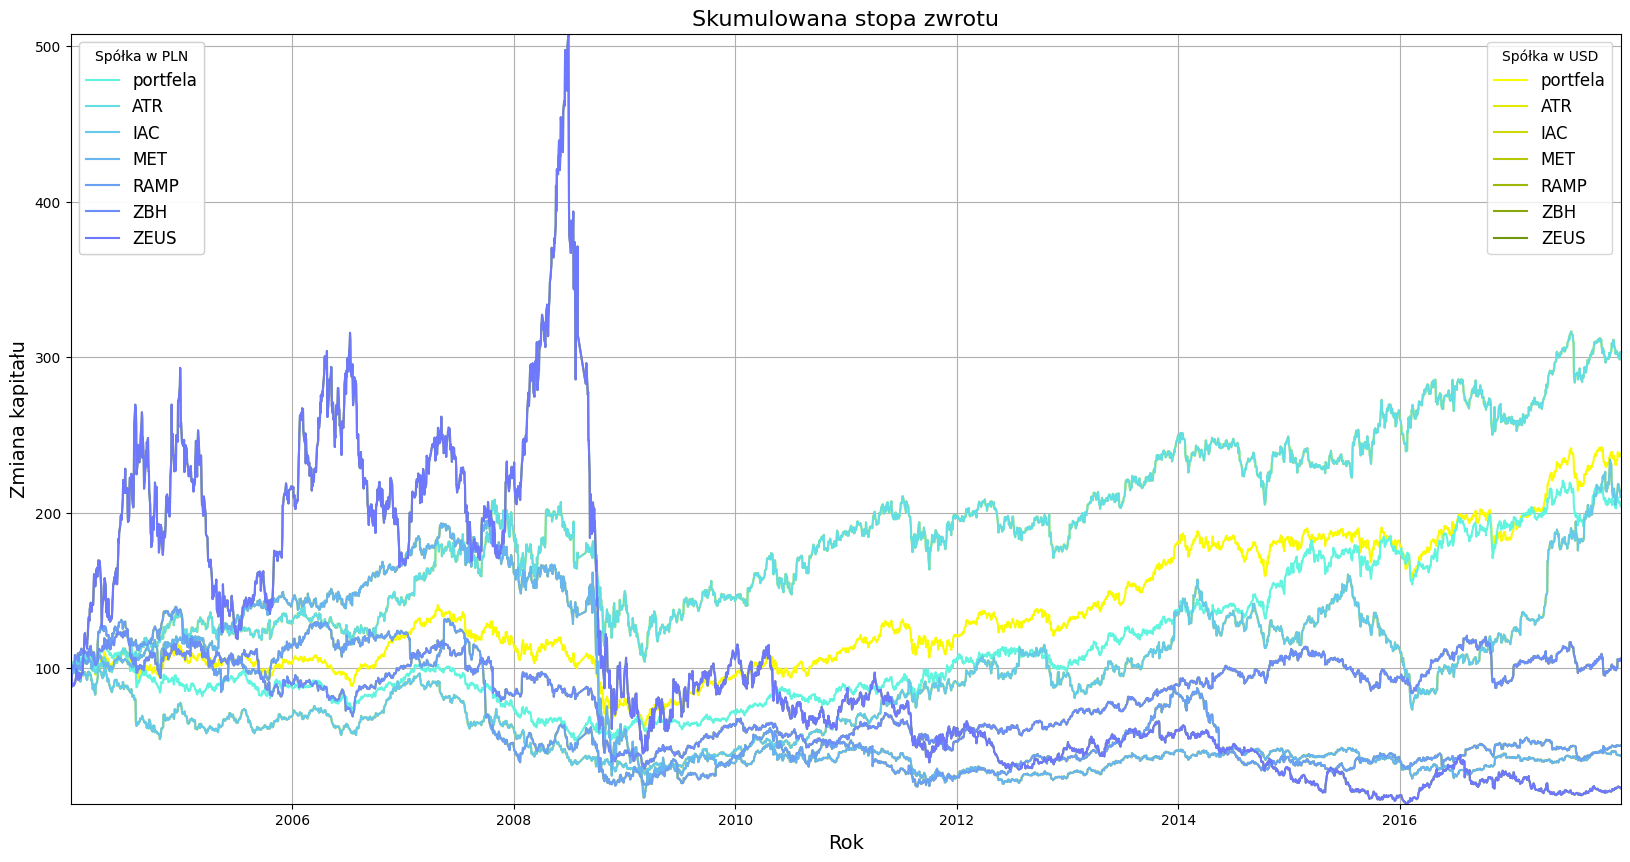

In [39]:
x = skumulowane_stopy_zwrotu["Date"]
y = ["SSZ portfela", "SSZ ATR", "SSZ IAC", "SSZ MET", "SSZ RAMP", "SSZ ZBH", "SSZ ZEUS"]
kolory1 = ["#fafa00", "#e3e902", "#ccd904", "#b5c806", "#9eb708", "#87a70a", "#70960c"]
plt.figure(figsize=(20, 10))
plt.grid()

lines1 = []
for spolka in range(len(y)):
    line, = plt.plot(x, skumulowane_stopy_zwrotu[y[spolka]], label=y[spolka].replace("SSZ ", ""), color=kolory1[spolka])
    lines1.append(line)

legend1 = plt.legend(lines1, [line.get_label() for line in lines1], title='Spółka w USD', loc=1, fontsize=12)

x2 = skumulowane_stopy_zwrotu_przewalutowane["Date"]

kolory2 = ["#61f4de", "#63dfe4", "#65cbe9", "#68b6ef", "#6aa1f4", "#6c8dfa", "#6e78ff"]
lines2 = []
for spolka2 in range(len(y)):
    line, = plt.plot(x2, skumulowane_stopy_zwrotu_przewalutowane[y[spolka2]], label=y[spolka2].replace("SSZ ", ""),
                     color=kolory2[spolka2])
    lines2.append(line)

legend2 = plt.legend(lines2, [line.get_label() for line in lines2], title='Spółka w PLN', loc=2, fontsize=12)

plt.xlabel("Rok", fontsize=14)
plt.ylabel("Zmiana kapitału", fontsize=14)
plt.title("Skumulowana stopa zwrotu", fontsize=16)
plt.autoscale(enable=None, axis="x", tight=True)
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

# plt.savefig('wykres4.png',  bbox_inches='tight', pad_inches=0.1)
plt.show()


Na pozór wykres nie różni się od wykresu z części podstawowej, natomiast dane spółek pokrywają się ze sobą, iż nie jesteśmy w stanie ich zobaczyć. Poniżej prezentujemy wykres z przesunięciem danych na osi y o 10.

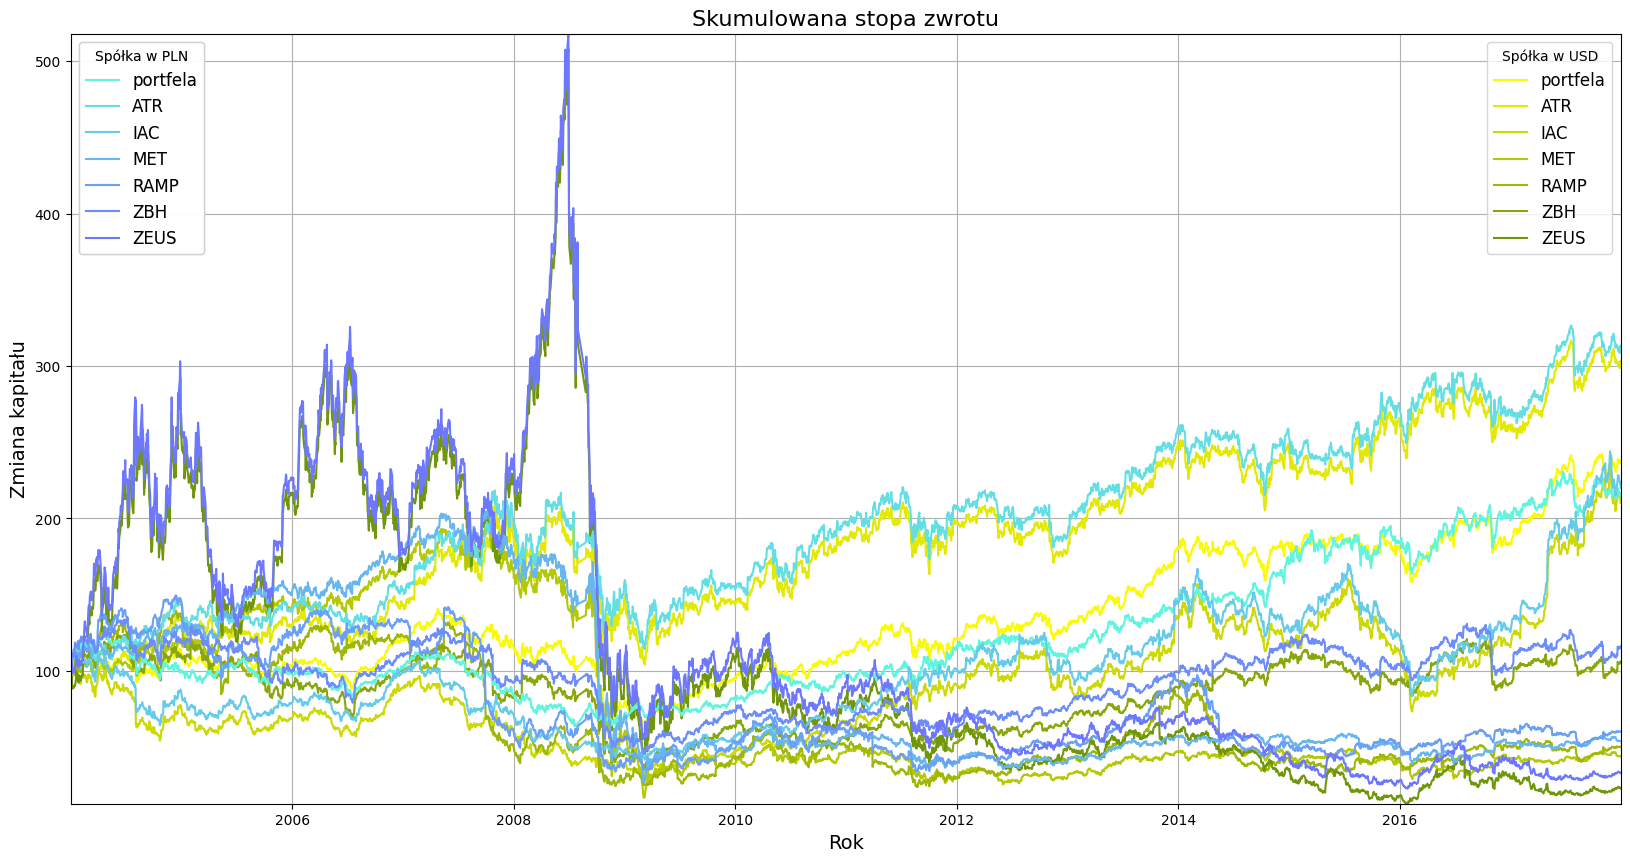

In [40]:
plt.figure(figsize=(20, 10))
plt.grid()

x = skumulowane_stopy_zwrotu["Date"]
y = ["SSZ portfela", "SSZ ATR", "SSZ IAC", "SSZ MET", "SSZ RAMP", "SSZ ZBH", "SSZ ZEUS"]
kolory1 = ["#fafa00", "#e3e902", "#ccd904", "#b5c806", "#9eb708", "#87a70a", "#70960c"]
lines1 = []
for spolka in range(len(y)):
    line, = plt.plot(x, skumulowane_stopy_zwrotu[y[spolka]], label=y[spolka].replace("SSZ ", ""), color=kolory1[spolka])
    lines1.append(line)
    
# Tworzymy dwie osobne legendy. jedną dla danych w dolarach a drugą dla złotówek.
legend1 = plt.legend(lines1, [line.get_label() for line in lines1], title='Spółka w USD', loc=1, fontsize=12)

x2 = skumulowane_stopy_zwrotu_przewalutowane["Date"]
kolory = ["#61f4de", "#63dfe4", "#65cbe9", "#68b6ef", "#6aa1f4", "#6c8dfa", "#6e78ff"]
lines2 = []
for spolka2 in range(len(y)):
    offset = 10  
    line, = plt.plot(x2, skumulowane_stopy_zwrotu_przewalutowane[y[spolka2]] + offset,
                     label=y[spolka2].replace("SSZ ", ""), color=kolory[spolka2])
    lines2.append(line)

legend2 = plt.legend(lines2, [line.get_label() for line in lines2], title='Spółka w PLN', loc=2, fontsize=12)

plt.xlabel("Rok", fontsize=14)
plt.ylabel("Zmiana kapitału", fontsize=14)
plt.title("Skumulowana stopa zwrotu", fontsize=16)
plt.autoscale(enable=None, axis="x", tight=True)
# dodajemy obie legendy do wykresu.
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)
# plt.savefig('wykres5.png',  bbox_inches='tight', pad_inches=0.1)
plt.show()

Doszliśmy do wniosku, że lepiej będzie zaprezentować dane na osobnych wykresach tak jak to zrobiliśmy poniżej.

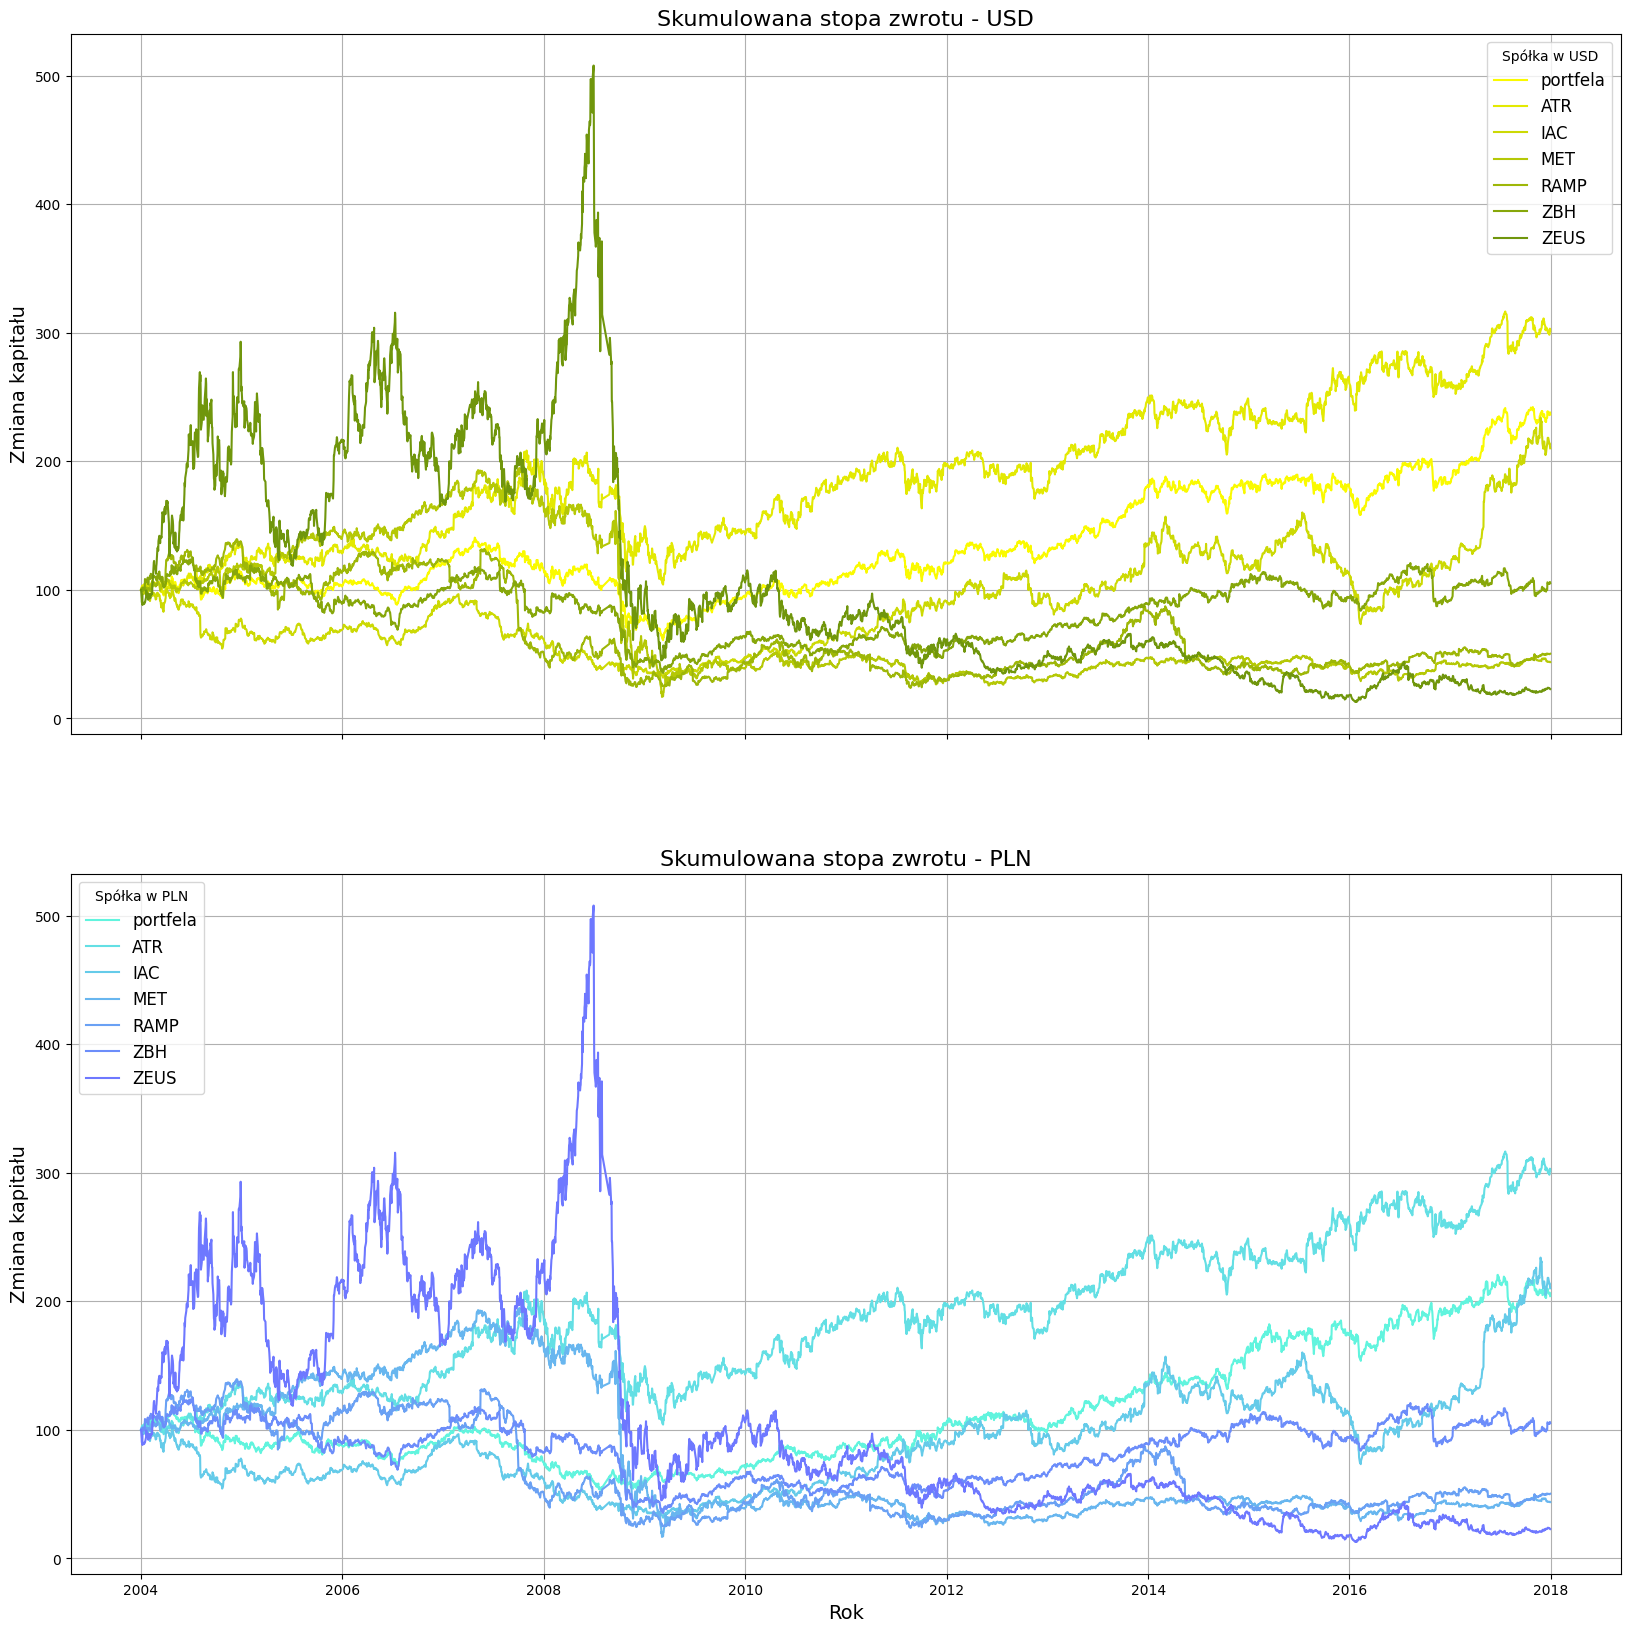

In [41]:
x = skumulowane_stopy_zwrotu["Date"]
y = ["SSZ portfela", "SSZ ATR", "SSZ IAC", "SSZ MET", "SSZ RAMP", "SSZ ZBH", "SSZ ZEUS"]
kolory1 = ["#fafa00", "#e3e902", "#ccd904", "#b5c806", "#9eb708", "#87a70a", "#70960c"]
kolory2 = ["#61f4de", "#63dfe4", "#65cbe9", "#68b6ef", "#6aa1f4", "#6c8dfa", "#6e78ff"]

fig, axs = plt.subplots(2, 1, figsize=(20, 20), sharex=True)

# pierwszy subplot
axs[0].grid()
lines1 = []
for spolka in range(len(y)):
    line, = axs[0].plot(x, skumulowane_stopy_zwrotu[y[spolka]], label=y[spolka].replace("SSZ ", ""), color=kolory1[spolka])
    lines1.append(line)

axs[0].legend(lines1, [line.get_label() for line in lines1], title='Spółka w USD', loc=1, fontsize=12)

axs[0].set_ylabel("Zmiana kapitału", fontsize=14)
axs[0].set_title("Skumulowana stopa zwrotu - USD", fontsize=16)

# drugi subplot
axs[1].grid()
lines2 = []
for spolka2 in range(len(y)):
    line, = axs[1].plot(x, skumulowane_stopy_zwrotu_przewalutowane[y[spolka2]],
                       label=y[spolka2].replace("SSZ ", ""), color=kolory2[spolka2])
    lines2.append(line)

axs[1].legend(lines2, [line.get_label() for line in lines2], title='Spółka w PLN', loc=2, fontsize=12)
axs[1].set_xlabel("Rok", fontsize=14)
axs[1].set_ylabel("Zmiana kapitału", fontsize=14)
axs[1].set_title("Skumulowana stopa zwrotu - PLN", fontsize=16)
# plt.savefig('wykres4.png',  bbox_inches='tight', pad_inches=0.1)
plt.show()


Na poniższym wykresie prezentujemy porównanie wyłącznie dla samych portfeli.

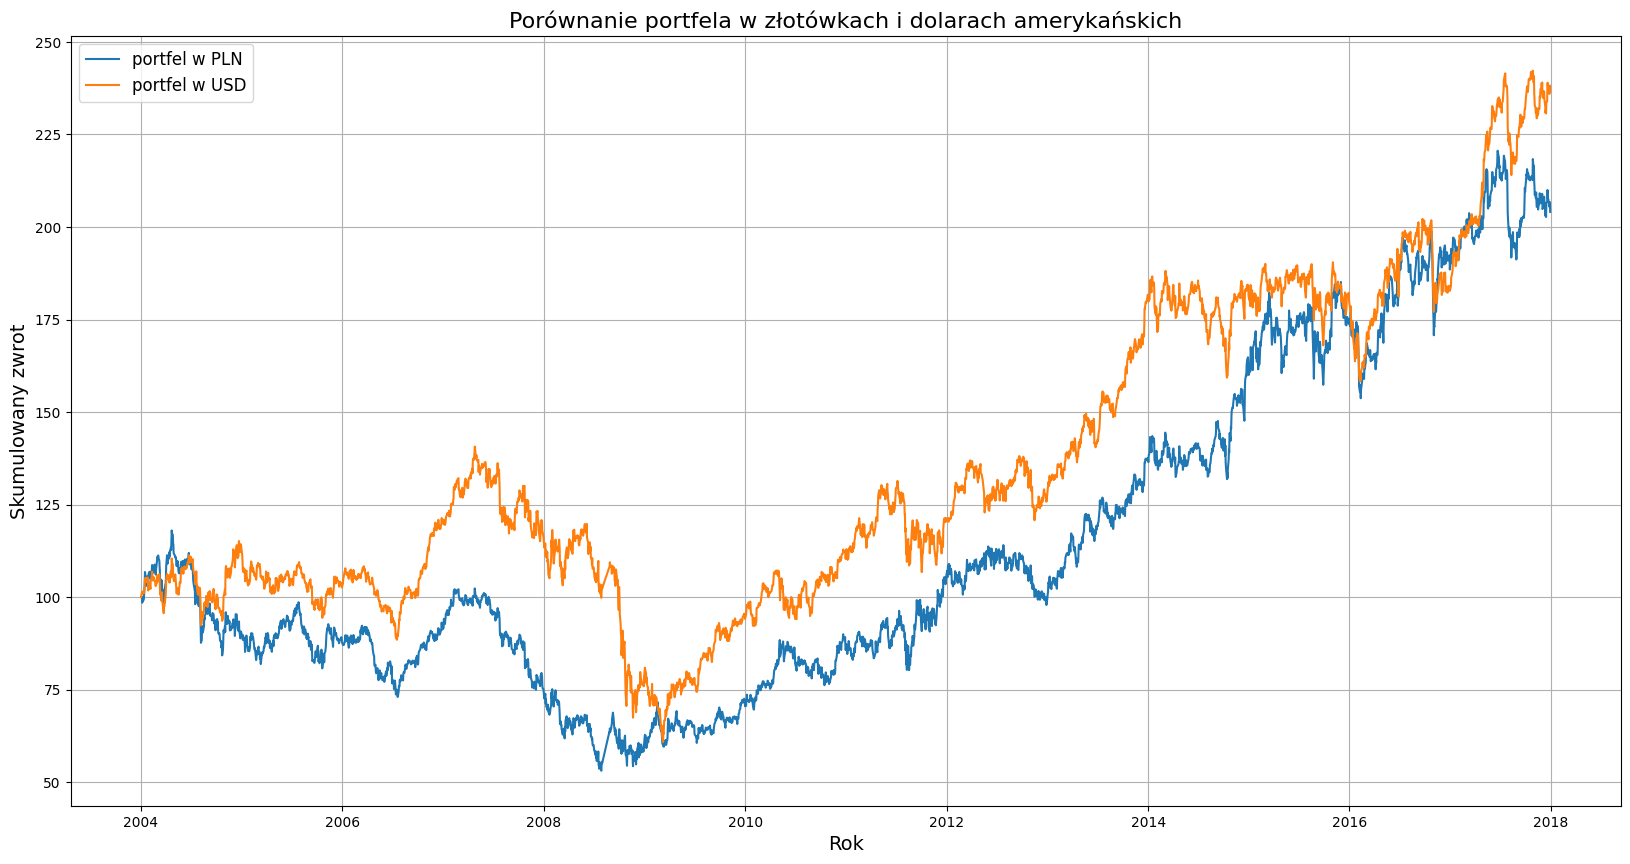

In [42]:
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(skumulowane_stopy_zwrotu["Date"], skumulowane_stopy_zwrotu_przewalutowane["SSZ portfela"], label="portfel w PLN")
plt.plot(skumulowane_stopy_zwrotu["Date"], skumulowane_stopy_zwrotu["SSZ portfela"], label="portfel w USD")

plt.xlabel('Rok', fontsize=14)
plt.ylabel('Skumulowany zwrot', fontsize=14)
plt.title('Porównanie portfela w złotówkach i dolarach amerykańskich', fontsize=16)
plt.legend(loc=2, fontsize=12)
plt.show()

## 7. Wykonaj porstą symulację swojego portfela:
- załóż, że dysponujesz 10 000 PLN,
- oblicz ile akcji każdej ze spółek możesz kupić (uwzględnij koszty transakcji),
- załóż, że portfel jest statyczny, tj. nie zmieniasz w nim wagi poszczególnych spółek,
- oblicz wartość portfela w czasie, zakładając że kupiłeś akcje w pierwszym dniu notowań, oraz że możesz kupować tylko pełne akcje.

Wybieramy dom maklerski XTB. Prowizja od wartości zakupu akcji wynosi 0,5% 

In [43]:
print("Prezentujemy dane potrzebne do przeprowadzenia symulacji.\n")
print(f"Ceny akcji w dniu {waluta.iloc[0,0]} w dolarach: \n{spolki_gieldowe.iloc[0,1:].to_string()}")
print(f"\nKurs dolara {np.round(waluta.iloc[0,1], 4)} zł w dniu {waluta.iloc[0,0]}.")

portfel = pd.Series(spolki_gieldowe.iloc[0,1:].values * waluta.iloc[0,1:].values, spolki_gieldowe.columns.values[1:])
print(f"\nCeny akcji po przewalutowaniu na złotówki:\n{portfel.to_string()}")
print(f"\nWagi portfela: \n{np.round(optymalne_wagi,6)}")


Prezentujemy dane potrzebne do przeprowadzenia symulacji.

Ceny akcji w dniu 2004-01-02 w dolarach: 
Ticker
ATR     19.280001
IAC      7.025336
MET     29.910873
RAMP    18.809999
ZBH     67.961166
ZEUS         8.11

Kurs dolara 3.7359 zł w dniu 2004-01-02.

Ceny akcji po przewalutowaniu na złotówki:
ATR      72.028153
IAC      26.245951
MET      111.74403
RAMP     70.272276
ZBH     253.896116
ZEUS     30.298147

Wagi portfela: 
[0.423921 0.231136 0.       0.028185 0.316757 0.      ]


In [44]:
saldo = 10000
koszyk = np.array([])
docelowo_przeznaczamy = saldo * optymalne_wagi
print("_"*60)
print("Wagi pokazują jak rozdysponowane zostały środki: ")
print(np.round(docelowo_przeznaczamy, 4))
print(f"suma = {sum(docelowo_przeznaczamy):.2f} zł")
print("_"*60)

symulacja = (docelowo_przeznaczamy // portfel).astype(int)
print("Następuje symulacja koszyka...")
print("_"*30)

print("Wyniki symulacji:")
print(symulacja.to_string())
print("_"*50)

saldo = saldo - sum(symulacja * portfel)
koszyk = symulacja.values
for i in range(np.size(koszyk)):
    print(f"Zakupiono {koszyk[i]} akcji spółki {symulacja.index[i]} wartych {koszyk[i]*portfel[i]:.2f} zł")
print("_"*80)

print(f"W sumie wartość koszyka wynosi = {sum(koszyk * portfel):.2f} zł")
print(f"Do tego należy doliczyć 0,5% kosztów transakcji, tj. {sum(koszyk * portfel):.2f} * 1.005 = {sum(koszyk * portfel) * 1.005:.2f} zł")
reszta = 10000 - sum(koszyk * portfel) * 1.005

print(f"Pozostała reszta = {reszta:.2f} zł")
print("_"*30)
      

____________________________________________________________
Wagi pokazują jak rozdysponowane zostały środki: 
[4239.213  2311.3619    0.      281.8525 3167.5726    0.    ]
suma = 10000.00 zł
____________________________________________________________
Następuje symulacja koszyka...
______________________________
Wyniki symulacji:
ATR     58
IAC     88
MET      0
RAMP     4
ZBH     12
ZEUS     0
__________________________________________________
Zakupiono 58 akcji spółki ATR wartych 4177.63 zł
Zakupiono 88 akcji spółki IAC wartych 2309.64 zł
Zakupiono 0 akcji spółki MET wartych 0.00 zł
Zakupiono 4 akcji spółki RAMP wartych 281.09 zł
Zakupiono 12 akcji spółki ZBH wartych 3046.75 zł
Zakupiono 0 akcji spółki ZEUS wartych 0.00 zł
________________________________________________________________________________
W sumie wartość koszyka wynosi = 9815.12 zł
Do tego należy doliczyć 0,5% kosztów transakcji, tj. 9815.12 * 1.005 = 9864.19 zł
Pozostała reszta = 135.81 zł
____________________________

C:\Users\Marcin\AppData\Local\Temp\ipykernel_3708\4244083848.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Zakupiono {koszyk[i]} akcji spółki {symulacja.index[i]} wartych {koszyk[i]*portfel[i]:.2f} zł")


## 8. Przedstaw wykres porównujący wynili portfela z symulacji oraz portfela z części podstawowej.

Tworzymy zbiór 14 danych dla obliczonej wcześniej rocznej stopy zwrotu portfela wynoszącej około 8%(Przypisaliśmy ją do zmiennej `stopa_zwrotu_portfela`).

In [45]:
przedzialy = np.linspace(0, 3494, 14).astype(int)
zakladana_wartosc_portfela = 10000
zakladana_zmiana_portfela = []
symulowana_zmiana_portfela = []
daty = []

for i in range(np.size(przedzialy)):
    zakladana_wartosc_portfela *= (1 + stopa_zwrotu_portfela)
    zakladana_zmiana_portfela.append(zakladana_wartosc_portfela)
    daty.append(spolki_gieldowe["Date"].values[przedzialy[i]])
    symulowana_zmiana_portfela.append((sum((przewalutowane_akcje.iloc[przedzialy[i], 1:] * symulacja))))

In [46]:
symulowany_portfel = pd.DataFrame({
    "Date": daty,
    "zakładana wartość portfela": zakladana_zmiana_portfela,
    "symulowana wartość portfela": symulowana_zmiana_portfela})
symulowany_portfel

,Date,zakładana wartość portfela,symulowana wartość portfela
0,2004-01-02,10806.092641,9815.119108
1,2005-01-27,11677.163817,8870.125080
2,2006-02-23,12618.451399,9352.859965
3,2007-03-21,13635.615481,10675.390870
4,2008-04-21,14734.772411,8374.895996
5,2009-06-10,15922.531572,8953.007754
6,2010-07-06,17206.035125,10636.580273
7,2011-07-29,18593.000955,12588.539659
8,2012-08-22,20091.769080,15431.489583
9,2013-09-18,21711.351800,17642.099474


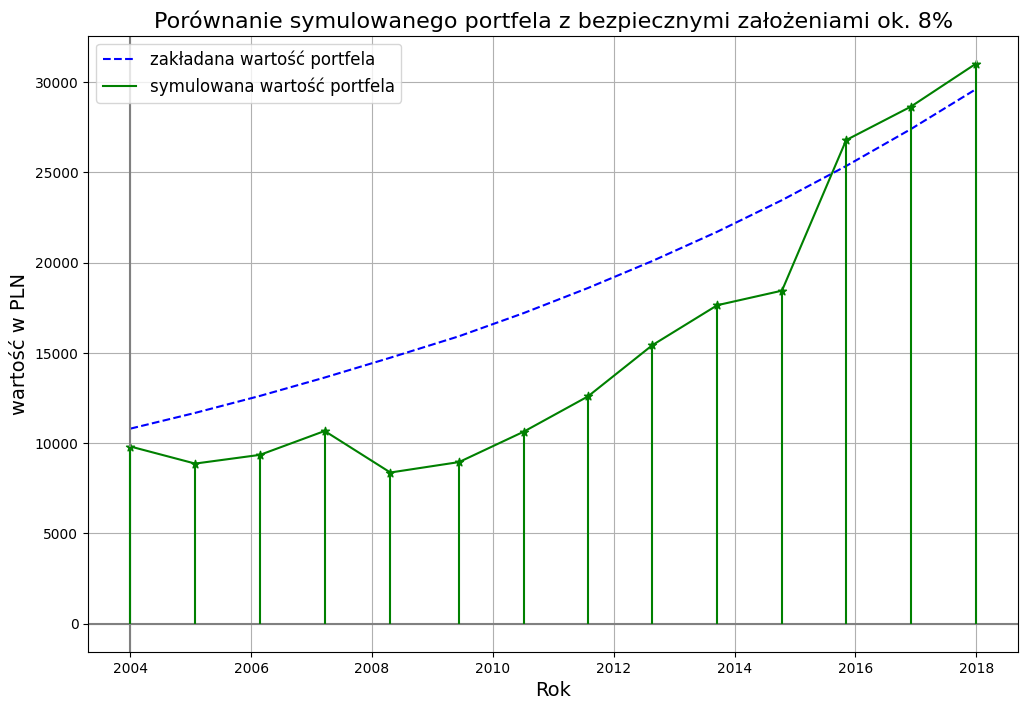

In [47]:
osx = symulowany_portfel["Date"]
osy1 = symulowany_portfel["zakładana wartość portfela"].values
osy2 = symulowany_portfel["symulowana wartość portfela"].values
plt.figure(figsize=(12, 8))
plt.grid()
plt.plot(osx, osy1, label="zakładana wartość portfela", color="blue", linestyle="--")
plt.plot(osx, osy2, label="symulowana wartość portfela", color="green")
plt.scatter(osx, symulowana_zmiana_portfela, color="green", marker="*")
plt.axvline(x=symulowany_portfel["Date"][0], c="grey")
plt.axhline(y=0, c="grey")
plt.vlines(x=symulowany_portfel["Date"], ymin=0, ymax=symulowany_portfel["symulowana wartość portfela"].values, color="green")
plt.legend(loc=2, fontsize=12)
plt.xlabel("Rok", fontsize=14)
plt.ylabel("wartość w PLN", fontsize=14)
plt.title("Porównanie symulowanego portfela z bezpiecznymi założeniami ok. 8%", fontsize=16)
plt.show()

#### Wnioski
Zgodnie z przyjętymi założeniami nasz symulowany portfel przekroczył próg 8% stopy zwrotu portfela.

## 9. Przedstaw wykres porównujący wagi poszczególnych spółek w portfelu z symulacji

[Text(0.5, 0, 'spółka'),
 Text(0, 0.5, 'procent %'),
 Text(0.5, 1.0, 'Rozłożenie wag między akcje spółek')]

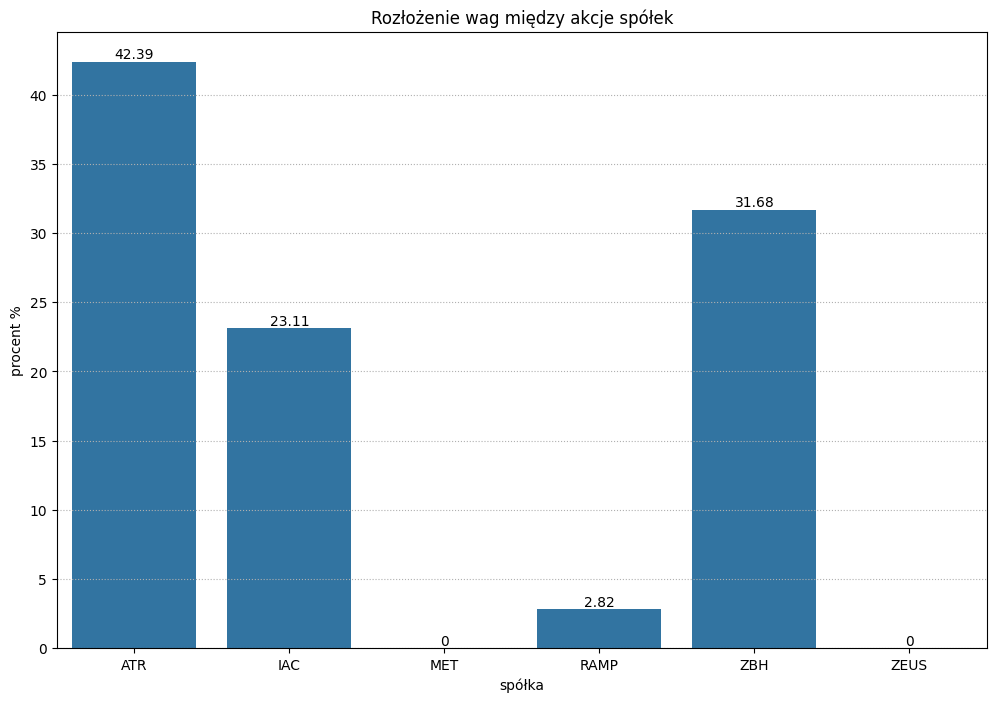

In [48]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.grid(linestyle=':')
sns.barplot(x=symulacja.index, y=np.round(optymalne_wagi*100,2), ax=ax)
ax.bar_label(ax.containers[0], label_type='edge')
ax.set(xlabel="spółka", ylabel="procent %", title="Rozłożenie wag między akcje spółek")